In [12]:
from tensorflow.keras.layers import Input


1/1 [==============================] - 0s 95ms/step
Epoch: 0, Discriminator Loss: [0.6684742569923401, 0.5], Generator Loss: 0.7323029041290283
1/1 [==============================] - 0s 19ms/step


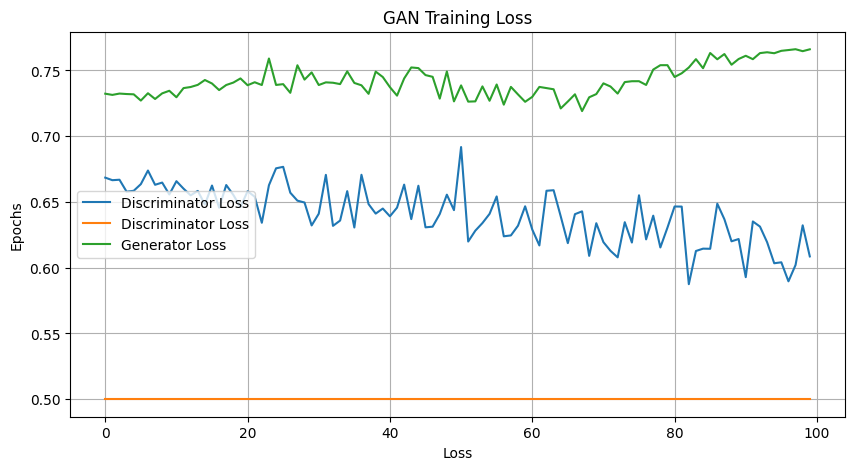

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

# Load the dataset
data = pd.read_csv("emails.csv")

# Preprocess the data
X = data['text']
y = data['spam']

# Convert text to numerical data (you can use techniques like TF-IDF or word embeddings)
# For simplicity, let's just use the length of the text
X = X.apply(lambda x: len(x))

# Standardize the numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the generator model
generator = Sequential([
    Dense(128, input_dim=1),
    LeakyReLU(alpha=0.2),
    BatchNormalization(),
    Dense(256),
    LeakyReLU(alpha=0.2),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Define the discriminator model
discriminator = Sequential([
    Dense(128, input_dim=1),
    LeakyReLU(alpha=0.2),
    Dense(64),
    LeakyReLU(alpha=0.2),
    Dense(1, activation='sigmoid')
])

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Compile the generator
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Define the GAN model
discriminator.trainable = False
gan_input = Input(shape=(1,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Train the GAN
def train_gan(generator, discriminator, gan, X_train, batch_size, epochs):
    d_loss = []
    g_loss = []

    for epoch in range(epochs):
        noise = np.random.normal(0, 1, size=[batch_size, 1])
        fake_data = generator.predict(noise)
        real_data = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

        X_batch = np.concatenate([real_data, fake_data])
        y_discriminator = np.zeros(2 * batch_size)
        y_discriminator[:batch_size] = 0.9  # Label smoothing

        discriminator.trainable = True
        d_loss.append(discriminator.train_on_batch(X_batch, y_discriminator))

        noise = np.random.normal(0, 1, size=[batch_size, 1])
        y_generator = np.ones(batch_size)
        discriminator.trainable = False
        g_loss.append(gan.train_on_batch(noise, y_generator))

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Discriminator Loss: {d_loss[-1]}, Generator Loss: {g_loss[-1]}")

    return d_loss, g_loss
def plot_loss(d_loss, g_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(d_loss, label='Discriminator Loss')
    plt.plot(g_loss, label='Generator Loss')
    plt.xlabel('Loss')
    plt.ylabel('Epochs')
    plt.title('GAN Training Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Set up hyperparameters
epochs = 100
batch_size = 32

# Train the GAN
d_loss, g_loss = train_gan(generator, discriminator, gan, X_train, batch_size, epochs)

# Plot the loss
plot_loss(d_loss, g_loss)


